In [1]:
from dfb.download import *
from dfb.databuilder import *
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from dfb.dataset import *
from dfb.trainmodule import *


2024-08-12 17:28:23.173116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 17:28:23.240485: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 17:28:23.549289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64/
2024-08-12 17:28:23.549328: W tensorflow/compiler/xla/stream_executor

In [2]:
class NumpyDataset(Dataset):
    def __init__(self, data, label, transform=None, target_transform=None):
        self.data = data
        self.label = label
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        x = np.array(self.data[idx, :]).astype("float32")
        t = np.array(self.label[idx]).astype("int64")

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            t = self.target_transform(t)

        return x, t
    
class NpToTensor:
    """numpy array를 텐서로 변환"""
    def __call__(self, x):
        return torch.from_numpy(x)
    
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')


In [3]:
thrs = 1000
batch_size = 32
sample_length = 256
shift = 128

df = {}
df['Adata'] = []
df['Bdata'] = []
df["fault_type"] = []
df['axis'] = []
df['label'] = []
output_dir = '../output'
date = '0724'
root = os.path.join(output_dir, date)

label_map = {
    'H' : 0,
    'B' : 1,
    'IR': 2,
    'OR': 3,
}

In [4]:
for fault_type, label in label_map.items():
    fault_dir = os.path.join(root, f'{date}_30204_{fault_type}_1200')
    for axis in ['x.csv', 'z.csv']:
        fault_file = os.path.join(fault_dir, axis)
        data = pd.read_csv(fault_file, header=None)
        Adata = data.iloc[:thrs, 0].values.flatten()  # 첫 번째 열 읽어 1차원 리스트로 변환
        Bdata = data.iloc[:thrs, 1].values.flatten() # 두 번째 열 읽어 1차원 리스트로 변환
        df['Adata'].append(Adata)
        df['Bdata'].append(Bdata)
        df['fault_type'].append(fault_type)
        df['axis'].append(axis[0])
        df['label'].append(label)

test_df = pd.DataFrame(df)


In [5]:
test_df

,Adata,Bdata,fault_type,axis,label
0,"[560.113012078197, 560.1827499564645, 559.5984...","[126.66089400898522, 126.64184077358584, 126.0...",H,x,0
1,"[80.78269206823559, 80.83881881732468, 81.4495...","[83.1707702733228, 83.35490255022796, 83.85045...",H,z,0
2,"[560.113012078197, 560.1827499564645, 559.5984...","[126.66089400898522, 126.64184077358584, 126.0...",B,x,1
3,"[80.78269206823559, 80.83881881732468, 81.4495...","[83.1707702733228, 83.35490255022796, 83.85045...",B,z,1
4,"[571.5700552208835, 571.3807334840492, 570.866...","[137.74482252265943, 137.53328278999243, 137.1...",IR,x,2
5,"[75.59088855421686, 75.58236623963828, 76.2945...","[77.97463162691781, 77.8556229466768, 78.71236...",IR,z,2
6,"[532.8056391069376, 532.866583662907, 533.0670...","[98.8265850480616, 98.87790927021695, 99.17019...",OR,x,3
7,"[80.79448805419021, 80.27718373126314, 80.3394...","[83.17577500798977, 82.67625739644971, 82.7847...",OR,z,3


In [6]:
for data in ['Adata', 'Bdata']:
    test_df[data] = test_df[data].apply(lambda x: x - np.mean(x))

In [7]:
def data_sampling(
        data_segment: np.ndarray, sample_length: int, shift: int, 
        num_classes:int, classID:int, is_onehot: bool = False
        )-> Tuple[np.ndarray, np.ndarray]:
    sampled_data = np.array([
        # data segment에서 sample_length만큼의 데이터를 shift만큼 이동해가며 np.ndarray 형태로 반환
        data_segment[i: i+sample_length]
        for i in range(0, len(data_segment)-sample_length, shift)
    ])
    if is_onehot: # 원 핫 인코딩
        label = np.zeros((sampled_data.shape[0], num_classes))
        label[:, classID] = 1
    else: # 레이블 인코딩
        label = np.zeros((sampled_data.shape[0]))
        label = label + classID
    
    return sampled_data, label

def build_from_dataframe(
        df: pd.DataFrame, sample_length: int, shift: int, dtype: str,
        is_onehot: bool = False
        )-> Tuple[np.ndarray, np.ndarray]:
    
    num_classes = test_df["label"].max() - test_df["label"].min() + 1
    num_data = test_df.shape[0]

    data = []
    label = []

    for i in range(num_data):
        data_segment = test_df.iloc[i][dtype]

        dataseg, labelseg = data_sampling(data_segment, sample_length, shift,
                                            num_classes, df.iloc[i]["label"], is_onehot)
                                            
        
        data.append(dataseg)
        label.append(labelseg)

    data_array = np.concatenate(tuple(data), axis=0)
    label_array = np.concatenate(tuple(label), axis=0)

    return data_array, label_array


Adata, Alabel = build_from_dataframe(test_df, sample_length, shift, dtype='Adata', is_onehot=False)
Bdata, Blabel = build_from_dataframe(test_df, sample_length, shift, dtype='Bdata', is_onehot=False)

In [8]:
Bdata

array([[ 0.41847994,  0.39942671, -0.1742277 , ...,  0.46998218,
        -0.11173721, -0.37617696],
       [-0.13707193, -0.44792503, -0.29385609, ..., -0.28638878,
        -0.33130796, -0.05031308],
       [-0.42861178, -0.00976243,  0.22870038, ..., -0.10682424,
         0.48268064,  0.49619325],
       ...,
       [-0.08021281, -0.41955004, -0.35054227, ..., -0.15327564,
        -0.08611116, -0.12538865],
       [-0.39952606, -0.06335617,  0.35253579, ...,  0.27441073,
         0.57221149,  0.18312077],
       [ 0.52900163,  0.2461176 , -0.12227854, ...,  0.24320898,
        -0.18602708, -0.18876586]])

In [9]:
class ExpandDim:
    """데이터를 한 차원만큼 확장"""
    def __call__(self, x):
        return np.expand_dims(x, axis = 0)

transform = transforms.Compose([
    # ExpandDim(),
    # ReSize(3, 32, 32),
    NpToTensor()
])

train_dataset_A = NumpyDataset(data=Adata, label=Alabel, 
                             transform=NpToTensor(), target_transform=NpToTensor())
train_dataset_B = NumpyDataset(data=Bdata, label=Blabel, 
                             transform=NpToTensor(), target_transform=NpToTensor())

In [10]:
train_loader_A = DataLoader(dataset=train_dataset_A, batch_size=batch_size, shuffle=True, drop_last=False)

train_loader_B = DataLoader(dataset=train_dataset_B, batch_size=batch_size, shuffle=True, drop_last=False)

In [11]:
print(len(train_dataset_A))

48


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Simple1DCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=4):
        super(Simple1DCNN, self).__init__()
        
        # 첫 번째 1D 컨볼루션 레이어
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # 두 번째 1D 컨볼루션 레이어
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        
        # 세 번째 1D 컨볼루션 레이어
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        
        # 전결층(Dense Layer)
        self.fc1 = nn.Linear(128 * 30, 128)  # Flattened size should match (adjust based on input size)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Dropout 레이어
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 30)  # Flatten (adjust based on the output size of conv layers)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # print(x.shape)
        
        return x

model = Simple1DCNN(num_classes=4).to(DEVICE)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [14]:
for batch in train_loader_A:
    
    X, y = batch
    X = X.unsqueeze(1)  # 1번 축에 채널 차원 추가

    print(f"입력 데이터 X의 형상: {X.shape}")
    print(f"라벨 y의 형상: {y.shape}")
    break  # 첫 번째 배치만 확인하고 루프 종료

입력 데이터 X의 형상: torch.Size([32, 1, 256])
라벨 y의 형상: torch.Size([32])


In [15]:
train_acc_list = []
train_loss_list = []

import torch

def train(model, train_loader, optimizer, device, criterion, batch_size):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        image = image.unsqueeze(1)
        label = label.to(device)
        # print(image.shape)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        prediction =  prediction.view_as(label)

    train_loss /= (len(train_loader.dataset) / batch_size)
    train_accuracy = correct / len(train_loader.dataset)

    return train_loss, train_accuracy
    
#test()
def test(model, test_loader, device, criterion, batch_size):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            prediction =  prediction.view_as(label)

    test_loss /= (len(test_loader.dataset) / batch_size)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

for epoch in range(1, 200 + 1):
    train_loss, train_accuracy = train(model, train_loader_A, optimizer, DEVICE, loss, batch_size)
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    print("[EPOCH: {}] \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.4f}".format(
        epoch, train_loss, train_accuracy))

[EPOCH: 1] 	Train Loss: 1.8883, 	Train Accuracy: 0.1875
[EPOCH: 2] 	Train Loss: 1.8503, 	Train Accuracy: 0.3333
[EPOCH: 3] 	Train Loss: 1.8428, 	Train Accuracy: 0.2292
[EPOCH: 4] 	Train Loss: 1.8434, 	Train Accuracy: 0.2708
[EPOCH: 5] 	Train Loss: 1.8531, 	Train Accuracy: 0.1667
[EPOCH: 6] 	Train Loss: 1.8498, 	Train Accuracy: 0.2292
[EPOCH: 7] 	Train Loss: 1.8248, 	Train Accuracy: 0.3750
[EPOCH: 8] 	Train Loss: 1.8186, 	Train Accuracy: 0.3958
[EPOCH: 9] 	Train Loss: 1.8008, 	Train Accuracy: 0.4375
[EPOCH: 10] 	Train Loss: 1.8040, 	Train Accuracy: 0.3542
[EPOCH: 11] 	Train Loss: 1.7872, 	Train Accuracy: 0.3542
[EPOCH: 12] 	Train Loss: 1.7738, 	Train Accuracy: 0.3750
[EPOCH: 13] 	Train Loss: 1.6694, 	Train Accuracy: 0.5208
[EPOCH: 14] 	Train Loss: 1.6502, 	Train Accuracy: 0.3958
[EPOCH: 15] 	Train Loss: 1.5825, 	Train Accuracy: 0.4375
[EPOCH: 16] 	Train Loss: 1.4892, 	Train Accuracy: 0.5000
[EPOCH: 17] 	Train Loss: 1.4245, 	Train Accuracy: 0.4583
[EPOCH: 18] 	Train Loss: 1.4230, 	Train 

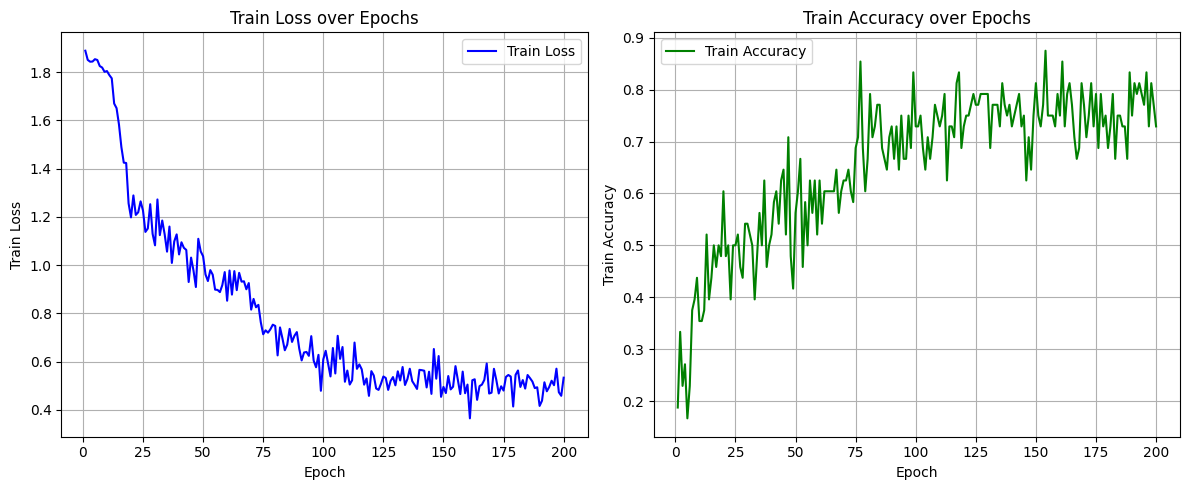

In [16]:
import matplotlib.pyplot as plt

# Assuming train_loss_list and train_acc_list have been populated during training
# epochs = range(1, len(train_loss_list) + 1)

def plot_training_curves(train_loss_list, train_acc_list):
    epochs = range(1, len(train_loss_list) + 1)  # Generate epoch numbers

    plt.figure(figsize=(12, 5))

    # Plot train loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title('Train Loss over Epochs')
    plt.grid(True)
    plt.legend()

    # Plot train accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_list, label='Train Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy over Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_curves(train_loss_list, train_acc_list)


In [17]:
epoch=0

train_acc_list = []
train_loss_list = []
for epoch in range(1, 200 + 1):
    train_loss, train_accuracy = train(model, train_loader_B, optimizer, DEVICE, loss, batch_size)
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    print("[EPOCH: {}] \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.4f}".format(
        epoch, train_loss, train_accuracy))

[EPOCH: 1] 	Train Loss: 0.5057, 	Train Accuracy: 0.8542
[EPOCH: 2] 	Train Loss: 0.5875, 	Train Accuracy: 0.7708
[EPOCH: 3] 	Train Loss: 0.6228, 	Train Accuracy: 0.7083
[EPOCH: 4] 	Train Loss: 0.4603, 	Train Accuracy: 0.7917
[EPOCH: 5] 	Train Loss: 0.6163, 	Train Accuracy: 0.6458
[EPOCH: 6] 	Train Loss: 0.5515, 	Train Accuracy: 0.7500
[EPOCH: 7] 	Train Loss: 0.6019, 	Train Accuracy: 0.6458
[EPOCH: 8] 	Train Loss: 0.5143, 	Train Accuracy: 0.6875
[EPOCH: 9] 	Train Loss: 0.5673, 	Train Accuracy: 0.6667
[EPOCH: 10] 	Train Loss: 0.4934, 	Train Accuracy: 0.6667
[EPOCH: 11] 	Train Loss: 0.4644, 	Train Accuracy: 0.7708
[EPOCH: 12] 	Train Loss: 0.5403, 	Train Accuracy: 0.6875
[EPOCH: 13] 	Train Loss: 0.5581, 	Train Accuracy: 0.6667
[EPOCH: 14] 	Train Loss: 0.5668, 	Train Accuracy: 0.7083
[EPOCH: 15] 	Train Loss: 0.4632, 	Train Accuracy: 0.8333
[EPOCH: 16] 	Train Loss: 0.5296, 	Train Accuracy: 0.7292
[EPOCH: 17] 	Train Loss: 0.4645, 	Train Accuracy: 0.7083
[EPOCH: 18] 	Train Loss: 0.5232, 	Train 

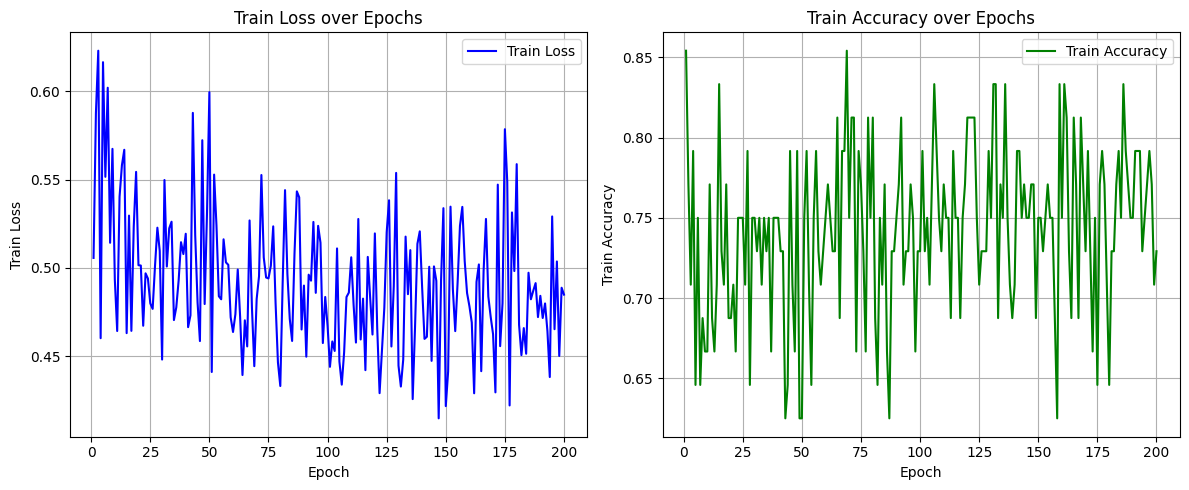

In [18]:
# Assuming train_loss_list and train_acc_list have been populated during training
# epochs = range(1, len(train_loss_list) + 1)
# Example usage
plot_training_curves(train_loss_list, train_acc_list)